In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
IDS=['AMT', 'XOM', 'T', 'SO', 'PFE', 'NVDA', 'NFLX', 'JPM', 'JNJ', 'GLD', 'MARK', 'GE', 'COST', 'AMZN', 'TSLA', 'AAPL']

This is the preliminary data analysis to create modelling assumptions, engineer new features, and find out how we can create a target to generate trading signals.

In [3]:
data=pd.read_csv('../../assets/data.csv', index_col=[0])
COLS=['DATE','CLOSE','HIGH','VOLUME','VOLATILITY_90D'] # I am only interested in the raw features

In [4]:
ID_DATA: dict[str, pd.DataFrame] = {i:data.loc[data.ID==i][COLS] for i in data.ID.unique()}

Peeking at the data, we see that the features are only available at the end of the trading day; the `HIGH` is only known when you collect all price information, `CLOSE` is the last observation of the day. Similarly, `VOLATILITY_90D` is a rolling calculation of returns so that information is also only known at the end of the trading day.

So **Assumption #1** will be that all the trading decisions we make can only be done at the end of the trading day because the raw features we have can only be observed at (daily) market close. The same goes for any engineered features because they are based on the raw features for any calculation. So any trades done on intra-day information will be look-ahead bias.

In [5]:
ID_DATA['AAPL']

,DATE,CLOSE,HIGH,VOLUME,VOLATILITY_90D
55023,2010-08-31,8.682,8.734,420786408,116.917
55010,2010-09-01,8.940,8.981,697035220,116.117
54993,2010-09-02,9.006,9.006,415425192,115.003
54978,2010-09-03,9.242,9.242,520788268,113.779
54972,2010-09-07,9.208,9.269,342825252,112.786
...,...,...,...,...,...
69,2024-04-29,173.500,176.030,68169419,57.168
52,2024-04-30,170.330,174.990,65934776,57.567
41,2024-05-01,169.300,172.705,50383147,57.342
21,2024-05-02,173.030,173.415,94214915,57.342


In [6]:
tickers = {
    "Inflation_Expectation": "TIP",  # iShares TIPS Bond ETF as a proxy for inflation expectations
    "Unemployment_Proxy": "SIVR",  # Aberdeen Standard Physical Silver Shares ETF (sometimes used as economic health indicator)
    "US_Economy": "SPY",  # SPDR S&P 500 ETF as a proxy for overall US economic health
    "Govt_Debt_Proxy": "TLT",  # iShares 20+ Year Treasury Bond ETF as a proxy for government debt
    "Treasury_10Y": "^TNX",  # 10-Year Treasury Yield
    "Treasury_5Y": "^FVX",  # 5-Year Treasury Yield
    "Treasury_2Y": "^IRX",  # 2-Year Treasury Yield
    "US_Dollar": "DX-Y.NYB",  # US Dollar Index
    "Gold": "GC=F",  # Gold Futures
    "Oil": "CL=F",  # Crude Oil Futures
    "VIX": "^VIX",  # CBOE Volatility Index
    "Real_Estate": "IYR",  # iShares U.S. Real Estate ETF
    "Consumer_Sentiment": "XLY"  # Consumer Discretionary Select Sector SPDR Fund
}

In [7]:
groups = []
for indicator, ticker in tickers.items():
    try:
        data = yf.download(ticker, start="2010-01-01", end="2024-08-20")
        if not data.empty:
            data.insert(0, "ID", indicator)
            data=data.drop(['Volume', 'Adj Close'],axis=1)
            groups.append(data)
        else:
            print(f"No data available for {indicator} ({ticker})")
    except Exception as e:
        print(f"Error downloading data for {indicator} ({ticker}): {str(e)}")

macro_data = pd.concat(groups)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


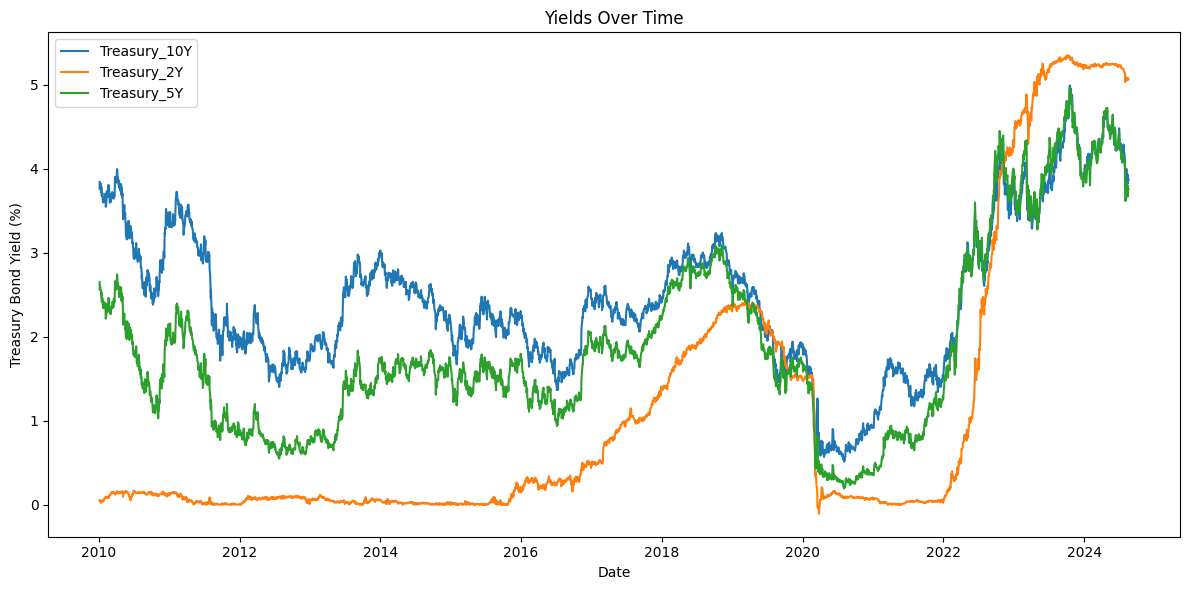

In [8]:
df_pivot = macro_data.loc[macro_data.ID.isin(['Treasury_10Y','Treasury_2Y','Treasury_5Y'])].pivot(columns='ID', values='Close')
feature1='Treasury_10Y'
feature2='Treasury_2Y'
feature3='Treasury_5Y'

plt.figure(figsize=(12, 6))
plt.plot(df_pivot.index, df_pivot[feature1], label=feature1)
plt.plot(df_pivot.index, df_pivot[feature2], label=feature2)
plt.plot(df_pivot.index, df_pivot[feature3], label=feature3)

plt.title(f"Yields Over Time")
plt.xlabel("Date")
plt.ylabel("Treasury Bond Yield (%)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
ID_DATA["MACRO"]=macro_data

In [10]:
market_index = "^GSPC"  # S&P 500
sector_etfs = {
    "Technology": "XLK",
    "Financial": "XLF",
    "Healthcare": "XLV",
    "Consumer_Discretionary": "XLY",
    "Consumer_Staples": "XLP",
    "Energy": "XLE",
    "Utilities": "XLU",
    "Materials": "XLB",
    "Industrial": "XLI",
    "Real_Estate": "XLRE",
    "Communication_Services": "XLC"
}

In [11]:
def download_and_calculate_returns(tickers, start_date, end_date):
    data = yf.download(list(tickers.values()) + [market_index], start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

def calculate_betas(returns, market_index):
    betas = {}
    market_returns = returns[market_index]
    
    for sector, ticker in sector_etfs.items():
        sector_returns = returns[ticker]
        beta, _, _, _, _ = stats.linregress(market_returns, sector_returns)
        betas[sector] = beta
    
    return pd.Series(betas)

[*********************100%%**********************]  12 of 12 completed


Sector Betas:
Technology                1.231926
Financial                 1.044104
Healthcare                0.738613
Consumer_Discretionary    1.087936
Consumer_Staples          0.599786
Energy                    1.033477
Utilities                 0.666978
Materials                 0.964228
Industrial                0.974477
Real_Estate               0.877627
Communication_Services    1.011360
dtype: float64


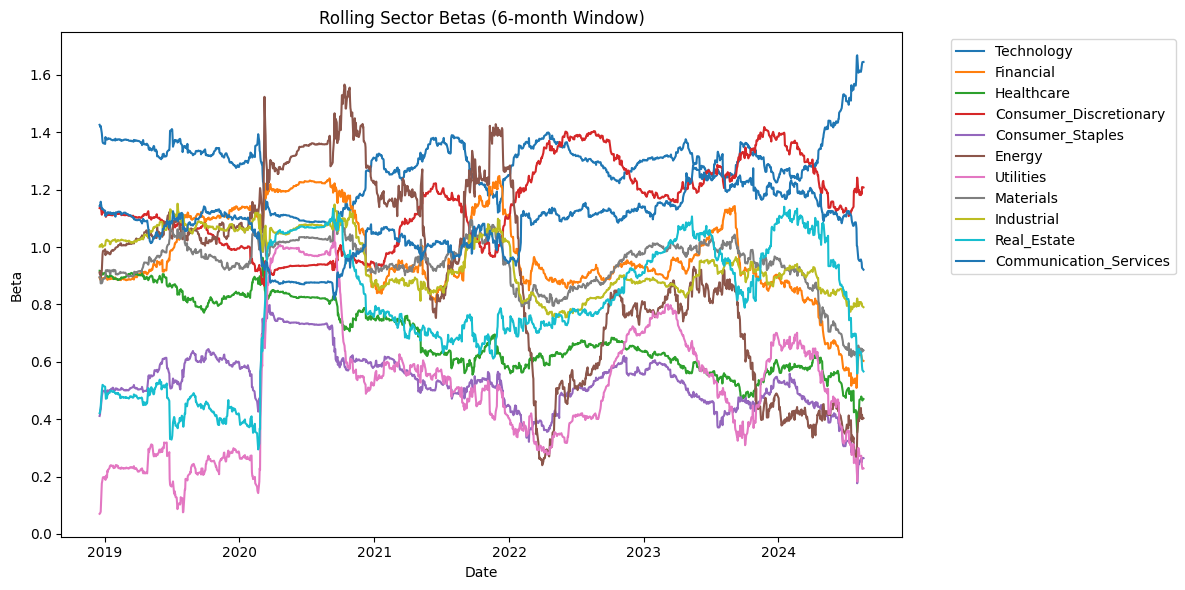

In [12]:
# Set date range
start_date = "2010-01-01"
end_date = "2024-08-20"

# Download data and calculate returns
returns = download_and_calculate_returns(sector_etfs, start_date, end_date)

# Calculate betas
sector_betas = calculate_betas(returns, market_index)

# Display sector betas
print("Sector Betas:")
print(sector_betas)

# Calculate rolling betas (e.g., 1-year rolling window)
window = 252//2  # Approximately 1 trading year
rolling_betas = pd.DataFrame(index=returns.index, columns=sector_etfs.keys())

for sector, ticker in sector_etfs.items():
    rolling_beta = returns[ticker].rolling(window=window).cov(returns[market_index]) / returns[market_index].rolling(window=window).var()
    rolling_betas[sector] = rolling_beta

plt.figure(figsize=(12, 6))
for sector in sector_etfs.keys():
    plt.plot(rolling_betas.index, rolling_betas[sector], label=sector)

plt.title("Rolling Sector Betas (6-month Window)")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
ID_DATA["STATIC_BETA"]=sector_betas
ID_DATA["BETA_6M"]=rolling_betas

In [14]:
ID_DATA.keys()

dict_keys(['AMT', 'XOM', 'T', 'SO', 'PFE', 'NVDA', 'NFLX', 'JPM', 'JNJ', 'GLD', 'MARK', 'GE', 'COST', 'AMZN', 'TSLA', 'AAPL', 'MACRO', 'STATIC_BETA', 'BETA_6M'])

In [19]:
start='2020-01-01'
end='2024-05-03'

for k,v in ID_DATA.items():
    print(k)
    
    if type(v) == pd.Series:
        continue

    print(v.columns.to_list())
    
    if 'DATE' in v.columns.to_list():
        v.DATE=pd.to_datetime(v.DATE)
        ID_DATA[k]=v.loc[(v.DATE >= start) & (v.DATE <= end)]

    elif 'Date' in v.columns.to_list():
        v.Date=pd.to_datetime(v.Date)
        ID_DATA[k]=v.loc[(v.Date >= start) & (v.Date <= end)]

    else:
        print('no date col found')

AMT
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
XOM
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
T
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
SO
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
PFE
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
NVDA
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
NFLX
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
JPM
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
JNJ
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
GLD
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
MARK
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
GE
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
COST
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
AMZN
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
TSLA
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
AAPL
['DATE', 'CLOSE', 'HIGH', 'VOLUME', 'VOLATILITY_90D']
MACRO
['Date', 'ID', 'Open', 'High', 'Low', 'Close']
BETA_6M
['Date',

/var/folders/zj/h0kz7p216vg8wfpn043t_y5w0000gn/T/ipykernel_60098/2403343265.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v.DATE=pd.to_datetime(v.DATE)


In [16]:
ID_DATA['MACRO'].reset_index(inplace=True)

In [17]:
ID_DATA['BETA_6M'].reset_index(inplace=True)

In [18]:
static_beta=ID_DATA['STATIC_BETA']
del ID_DATA['STATIC_BETA']

In [20]:
d=ID_DATA['MACRO']

for i in d.ID.unique():
    temp=d.loc[d.ID==i].drop(['ID'],axis=1)
    ID_DATA[i.upper()]=temp

In [21]:
del ID_DATA['MACRO']

In [22]:
import pandas as pd

def create_master_dataframe(data_dict):
    # Define the expected columns
    expected_columns = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'VOLATILITY_90D']
    
    # Create a list to store data for each row
    rows = []
    
    for id, df in data_dict.items():
        # Standardize column names
        df.columns = df.columns.str.upper()
        df = df.rename(columns={
            'DATE': 'DATE',
            'CLOSE': 'CLOSE',
            'HIGH': 'HIGH',
            'OPEN': 'OPEN',
            'LOW': 'LOW',
            'VOLUME': 'VOLUME'
        })
        
        # Ensure 'DATE' is the index
        if 'DATE' in df.columns:
            df = df.set_index('DATE')
        
        # For each date in the dataframe
        for date, row in df.iterrows():
            new_row = {'ID': id, 'DATE': date}
            
            # Add data for each expected column
            for col in expected_columns:
                if col in df.columns:
                    new_row[col] = row[col]
                else:
                    new_row[col] = None  # or pd.NA for pandas nullable type
            
            rows.append(new_row)
    
    # Create the master dataframe
    master_df = pd.DataFrame(rows)
    
    # Set the column order
    column_order = ['ID', 'DATE'] + expected_columns
    master_df = master_df[column_order]
    
    # Set 'DATE' as the index
    master_df = master_df.set_index('DATE')
    
    return master_df

In [23]:
df = create_master_dataframe(ID_DATA)

In [35]:
df

,ID,OPEN,HIGH,LOW,CLOSE,VOLUME,VOLATILITY_90D
DATE,,,,,,,
2020-01-02,AMT,NaN,231.150000,NaN,228.500000,1425971.0,23.300
2020-01-03,AMT,NaN,229.830000,NaN,228.610000,1598897.0,23.300
2020-01-06,AMT,NaN,230.000000,NaN,228.550000,1526810.0,23.298
2020-01-07,AMT,NaN,227.570000,NaN,223.680000,1464433.0,23.584
2020-01-08,AMT,NaN,226.485000,NaN,225.620000,1434323.0,23.633
...,...,...,...,...,...,...,...
2024-07-25,CONSUMER_SENTIMENT,181.270004,183.759995,180.039993,180.589996,NaN,NaN
2024-07-26,CONSUMER_SENTIMENT,181.919998,183.570007,181.460007,182.610001,NaN,NaN
2024-07-29,CONSUMER_SENTIMENT,183.839996,186.339996,183.740005,185.660004,NaN,NaN


In [25]:
df=df.drop(['LOW','OPEN'],axis=1)

In [26]:
df.loc[df.ID=='CONSUMER_SENTIMENT'].HIGH

DATE
2020-01-02    126.910004
2020-01-03    126.199997
2020-01-06    126.209999
2020-01-07    126.269997
2020-01-08    127.050003
                 ...    
2024-04-29    180.279999
2024-04-30    179.080002
2024-05-01    177.940002
2024-05-02    177.059998
2024-05-03    179.990005
Name: HIGH, Length: 1092, dtype: float64

In [27]:
equity_data=df.loc[df.ID.isin(IDS)]

In [28]:
df.isna().sum()

ID                    0
HIGH               1092
CLOSE              1092
VOLUME            15290
VOLATILITY_90D    16382
dtype: int64

In [29]:
df['VOlUME']=df.VOLUME.fillna(0)

In [30]:
del df['VOlUME']

In [31]:
df['VOLUME'].fillna(0, inplace=True)

In [32]:
df

,ID,HIGH,CLOSE,VOLUME,VOLATILITY_90D
DATE,,,,,
2020-01-02,AMT,231.150000,228.500000,1425971.0,23.300
2020-01-03,AMT,229.830000,228.610000,1598897.0,23.300
2020-01-06,AMT,230.000000,228.550000,1526810.0,23.298
2020-01-07,AMT,227.570000,223.680000,1464433.0,23.584
2020-01-08,AMT,226.485000,225.620000,1434323.0,23.633
...,...,...,...,...,...
2024-04-29,CONSUMER_SENTIMENT,180.279999,180.000000,0.0,NaN
2024-04-30,CONSUMER_SENTIMENT,179.080002,175.619995,0.0,NaN
2024-05-01,CONSUMER_SENTIMENT,177.940002,174.520004,0.0,NaN


In [33]:
print(sector_betas.index, df.ID.unique())

Index(['Technology', 'Financial', 'Healthcare', 'Consumer_Discretionary',
       'Consumer_Staples', 'Energy', 'Utilities', 'Materials', 'Industrial',
       'Real_Estate', 'Communication_Services'],
      dtype='object') ['AMT' 'XOM' 'T' 'SO' 'PFE' 'NVDA' 'NFLX' 'JPM' 'JNJ' 'GLD' 'MARK' 'GE'
 'COST' 'AMZN' 'TSLA' 'AAPL' 'BETA_6M' 'INFLATION_EXPECTATION'
 'UNEMPLOYMENT_PROXY' 'US_ECONOMY' 'GOVT_DEBT_PROXY' 'TREASURY_10Y'
 'TREASURY_5Y' 'TREASURY_2Y' 'US_DOLLAR' 'GOLD' 'OIL' 'VIX' 'REAL_ESTATE'
 'CONSUMER_SENTIMENT']


In [34]:
sector_ticker_dict = {
    'Technology': ['NVDA', 'AAPL'],
    'Financial': ['JPM'],
    'Healthcare': ['PFE', 'JNJ'],
    'Consumer_Discretionary': ['AMZN', 'TSLA'],
    'Consumer_Staples': ['COST'],
    'Energy': ['XOM'],
    'Utilities': ['SO'],
    'Materials': ['GLD'],
    'Industrial': ['GE'],
    'Real_Estate': ['AMT'],
    'Communication_Services': ['T', 'NFLX']
}

In [39]:
df.reset_index(inplace=True)
equity_data.reset_index(inplace=True)

In [36]:
df[df.ID=='TREASURY_5Y'].HIGH

24024    1.685
24025    1.634
24026    1.621
24027    1.620
24028    1.668
         ...  
25111    4.669
25112    4.723
25113    4.723
25114    4.655
25115    4.558
Name: HIGH, Length: 1092, dtype: float64

In [37]:

# List of macro features to add
macro_features = ['INFLATION_EXPECTATION', 'UNEMPLOYMENT_PROXY', 'US_ECONOMY', 'GOVT_DEBT_PROXY', 
                  'TREASURY_10Y', 'TREASURY_5Y', 'TREASURY_2Y', 'US_DOLLAR', 'GOLD', 'OIL', 
                  'VIX', 'REAL_ESTATE', 'CONSUMER_SENTIMENT']

macro_data = df[df.ID.isin(macro_features)]

macro_data=macro_data[['DATE','ID','HIGH']]
macro_data

,DATE,ID,HIGH
18564,2020-01-02,INFLATION_EXPECTATION,117.190002
18565,2020-01-03,INFLATION_EXPECTATION,117.830002
18566,2020-01-06,INFLATION_EXPECTATION,117.839996
18567,2020-01-07,INFLATION_EXPECTATION,117.260002
18568,2020-01-08,INFLATION_EXPECTATION,117.180000
...,...,...,...
32757,2024-04-29,CONSUMER_SENTIMENT,180.279999
32758,2024-04-30,CONSUMER_SENTIMENT,179.080002
32759,2024-05-01,CONSUMER_SENTIMENT,177.940002
32760,2024-05-02,CONSUMER_SENTIMENT,177.059998


In [40]:
equity_data['DATE'] = pd.to_datetime(equity_data['DATE'])
macro_data['DATE'] = pd.to_datetime(macro_data['DATE'])

# Reshape macro_data from long to wide format
macro_data_wide = macro_data.pivot(index='DATE', columns='ID', values='HIGH')
macro_data_wide.columns = ['MACRO_' + col for col in macro_data_wide.columns]  # Prefix macro columns
macro_data_wide.columns.name = None  # Remove the name from the columns index

# List of macro features (should match the unique IDs in macro_data)
macro_features = ['INFLATION_EXPECTATION', 'UNEMPLOYMENT_PROXY', 'US_ECONOMY', 'GOVT_DEBT_PROXY', 
                  'TREASURY_10Y', 'TREASURY_5Y', 'TREASURY_2Y', 'US_DOLLAR', 'GOLD', 'OIL', 
                  'VIX', 'REAL_ESTATE', 'CONSUMER_SENTIMENT']

# Ensure all expected features are present
for feature in macro_features:
    if f'MACRO_{feature}' not in macro_data_wide.columns:
        print(f"Warning: {feature} not found in macro data")

# Function to add macro features to a single ID's data
def add_macro_features(group):
    return pd.merge(group, macro_data_wide, left_on='DATE', right_index=True, how='left')

# Apply the function to each ID group
equity_data_with_macro = equity_data.groupby('ID', group_keys=False).apply(add_macro_features).reset_index(drop=True)

/var/folders/zj/h0kz7p216vg8wfpn043t_y5w0000gn/T/ipykernel_60098/31959770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equity_data['DATE'] = pd.to_datetime(equity_data['DATE'])


In [41]:
equity_data_with_macro[equity_data_with_macro.ID=='AAPL'].MACRO_INFLATION_EXPECTATION

16380    117.190002
16381    117.830002
16382    117.839996
16383    117.260002
16384    117.180000
            ...    
17467    106.120003
17468    105.839996
17469    105.360001
17470    105.470001
17471    106.120003
Name: MACRO_INFLATION_EXPECTATION, Length: 1092, dtype: float64

In [42]:
equity_data_with_macro[equity_data_with_macro.ID=='NVDA'].MACRO_INFLATION_EXPECTATION

5460    117.190002
5461    117.830002
5462    117.839996
5463    117.260002
5464    117.180000
           ...    
6547    106.120003
6548    105.839996
6549    105.360001
6550    105.470001
6551    106.120003
Name: MACRO_INFLATION_EXPECTATION, Length: 1092, dtype: float64

In [44]:
equity_data_with_macro.dropna(inplace=True)

In [137]:
ID_DATA['BETA_6M'].columns

Index(['INDEX', 'DATE', 'TECHNOLOGY', 'FINANCIAL', 'HEALTHCARE',
       'CONSUMER_DISCRETIONARY', 'CONSUMER_STAPLES', 'ENERGY', 'UTILITIES',
       'MATERIALS', 'INDUSTRIAL', 'REAL_ESTATE', 'COMMUNICATION_SERVICES'],
      dtype='object')

In [138]:
equity_data_with_macro

,DATE,ID,HIGH,CLOSE,VOLUME,VOLATILITY_90D,BETA,MACRO_CONSUMER_SENTIMENT,MACRO_GOLD,MACRO_GOVT_DEBT_PROXY,MACRO_INFLATION_EXPECTATION,MACRO_OIL,MACRO_REAL_ESTATE,MACRO_TREASURY_10Y,MACRO_TREASURY_2Y,MACRO_TREASURY_5Y,MACRO_UNEMPLOYMENT_PROXY,MACRO_US_DOLLAR,MACRO_US_ECONOMY,MACRO_VIX
0,2020-01-02,AMT,231.150,228.50,1425971.0,23.300,0.877627,126.910004,1528.699951,137.529999,117.190002,61.599998,93.540001,1.903,1.510,1.685,17.520000,96.870003,324.890015,13.720000
1,2020-01-03,AMT,229.830,228.61,1598897.0,23.300,0.877627,126.199997,1552.699951,139.160004,117.830002,64.089996,92.940002,1.840,1.490,1.634,17.580000,97.110001,323.640015,16.200001
2,2020-01-06,AMT,230.000,228.55,1526810.0,23.298,0.877627,126.209999,1580.000000,139.710007,117.839996,64.720001,93.129997,1.816,1.490,1.621,17.830000,96.900002,323.730011,16.389999
3,2020-01-07,AMT,227.570,223.68,1464433.0,23.584,0.877627,126.269997,1576.300049,138.470001,117.260002,63.150002,92.580002,1.828,1.505,1.620,17.850000,97.089996,323.540009,14.460000
4,2020-01-08,AMT,226.485,225.62,1434323.0,23.633,0.877627,127.050003,1604.199951,138.309998,117.180000,65.650002,92.330002,1.876,1.493,1.668,17.830000,97.330002,325.779999,15.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,2024-04-29,AAPL,176.030,173.50,68169419.0,57.168,1.231925,180.279999,2345.500000,89.019997,106.120003,83.910004,84.339996,4.649,5.248,4.669,26.240000,106.080002,510.750000,15.420000
17468,2024-04-30,AAPL,174.990,170.33,65934776.0,57.567,1.231925,179.080002,2322.500000,88.730003,105.839996,83.300003,83.900002,4.686,5.248,4.723,25.510000,106.349998,509.559998,15.900000
17469,2024-05-01,AAPL,172.705,169.30,50383147.0,57.342,1.231925,177.940002,2327.300049,89.209999,105.360001,81.570000,84.239998,4.676,5.255,4.723,25.790001,106.489998,508.190002,16.219999
17470,2024-05-02,AAPL,173.415,173.03,94214915.0,57.342,1.231925,177.059998,2324.699951,89.010002,105.470001,79.900002,84.099998,4.651,5.243,4.655,25.600000,105.900002,505.890015,16.090000


In [46]:
# Group by ID and shift the data by one day
equity_data_with_macro = equity_data_with_macro.groupby('ID').apply(lambda x: x.shift(-1)).reset_index(drop=True)

# Remove the last row for each ID (which will be NaN after shifting)
equity_data_with_macro = equity_data_with_macro.groupby('ID').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

for sector, tickers in sector_ticker_dict.items():
    beta_values = ID_DATA['BETA_6M'][sector.upper()].values
    for ticker in tickers:
        ticker_mask = equity_data_with_macro['ID'] == ticker
        ticker_length = ticker_mask.sum()
        
        if ticker_length > 0:
            # Ensure beta_values matches the length of the ticker data
            adjusted_beta_values = np.resize(beta_values, ticker_length)
            equity_data_with_macro.loc[ticker_mask, 'BETA_TS'] = adjusted_beta_values
        else:
            print(f"No data found for ticker {ticker}")

# Check the result
print(equity_data_with_macro[['ID', 'BETA_TS']].head(10))
print(equity_data_with_macro['BETA_TS'].isna().sum())

No data found for ticker GLD
     ID   BETA_TS
0  AAPL  1.289092
1  AAPL  1.291651
2  AAPL  1.289429
3  AAPL  1.288072
4  AAPL  1.289394
5  AAPL  1.291087
6  AAPL  1.290210
7  AAPL  1.292836
8  AAPL  1.290910
9  AAPL  1.295730
1090


In [47]:
equity_data_with_macro.loc[equity_data_with_macro.ID=='AAPL']

,DATE,ID,HIGH,CLOSE,VOLUME,VOLATILITY_90D,MACRO_CONSUMER_SENTIMENT,MACRO_GOLD,MACRO_GOVT_DEBT_PROXY,MACRO_INFLATION_EXPECTATION,MACRO_OIL,MACRO_REAL_ESTATE,MACRO_TREASURY_10Y,MACRO_TREASURY_2Y,MACRO_TREASURY_5Y,MACRO_UNEMPLOYMENT_PROXY,MACRO_US_DOLLAR,MACRO_US_ECONOMY,MACRO_VIX,BETA_TS
0,2020-01-03,AAPL,75.145,74.358,146535512.0,46.802,126.199997,1552.699951,139.160004,117.830002,64.089996,92.940002,1.840,1.490,1.634,17.580000,97.110001,323.640015,16.200001,1.289092
1,2020-01-06,AAPL,74.990,74.950,118578576.0,46.838,126.209999,1580.000000,139.710007,117.839996,64.720001,93.129997,1.816,1.490,1.621,17.830000,96.900002,323.730011,16.389999,1.291651
2,2020-01-07,AAPL,75.225,74.598,111510620.0,46.995,126.269997,1576.300049,138.470001,117.260002,63.150002,92.580002,1.828,1.505,1.620,17.850000,97.089996,323.540009,14.460000,1.289429
3,2020-01-08,AAPL,76.110,75.798,132363784.0,47.457,127.050003,1604.199951,138.309998,117.180000,65.650002,92.330002,1.876,1.493,1.668,17.830000,97.330002,325.779999,15.240000,1.288072
4,2020-01-09,AAPL,77.608,77.408,170486168.0,47.713,127.489998,1555.699951,137.440002,116.919998,60.310001,92.400002,1.900,1.503,1.691,17.400000,97.559998,326.730011,13.240000,1.289394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,2024-04-26,AAPL,171.340,169.300,44838354.0,51.507,177.100006,2347.899902,88.610001,105.910004,84.459999,84.050003,4.690,5.240,4.723,26.389999,106.190002,509.880005,16.059999,1.341189
1086,2024-04-29,AAPL,176.030,173.500,68169419.0,57.168,180.279999,2345.500000,89.019997,106.120003,83.910004,84.339996,4.649,5.248,4.669,26.240000,106.080002,510.750000,15.420000,1.357633
1087,2024-04-30,AAPL,174.990,170.330,65934776.0,57.567,179.080002,2322.500000,88.730003,105.839996,83.300003,83.900002,4.686,5.248,4.723,25.510000,106.349998,509.559998,15.900000,1.352215
1088,2024-05-01,AAPL,172.705,169.300,50383147.0,57.342,177.940002,2327.300049,89.209999,105.360001,81.570000,84.239998,4.676,5.255,4.723,25.790001,106.489998,508.190002,16.219999,1.365514


In [50]:
equity_data_with_macro.dropna(inplace=True)

In [51]:
equity_data_with_macro

,DATE,ID,HIGH,CLOSE,VOLUME,VOLATILITY_90D,MACRO_CONSUMER_SENTIMENT,MACRO_GOLD,MACRO_GOVT_DEBT_PROXY,MACRO_INFLATION_EXPECTATION,MACRO_OIL,MACRO_REAL_ESTATE,MACRO_TREASURY_10Y,MACRO_TREASURY_2Y,MACRO_TREASURY_5Y,MACRO_UNEMPLOYMENT_PROXY,MACRO_US_DOLLAR,MACRO_US_ECONOMY,MACRO_VIX,BETA_TS
0,2020-01-03,AAPL,75.145,74.358,146535512.0,46.802,126.199997,1552.699951,139.160004,117.830002,64.089996,92.940002,1.840,1.490,1.634,17.580000,97.110001,323.640015,16.200001,1.289092
1,2020-01-06,AAPL,74.990,74.950,118578576.0,46.838,126.209999,1580.000000,139.710007,117.839996,64.720001,93.129997,1.816,1.490,1.621,17.830000,96.900002,323.730011,16.389999,1.291651
2,2020-01-07,AAPL,75.225,74.598,111510620.0,46.995,126.269997,1576.300049,138.470001,117.260002,63.150002,92.580002,1.828,1.505,1.620,17.850000,97.089996,323.540009,14.460000,1.289429
3,2020-01-08,AAPL,76.110,75.798,132363784.0,47.457,127.050003,1604.199951,138.309998,117.180000,65.650002,92.330002,1.876,1.493,1.668,17.830000,97.330002,325.779999,15.240000,1.288072
4,2020-01-09,AAPL,77.608,77.408,170486168.0,47.713,127.489998,1555.699951,137.440002,116.919998,60.310001,92.400002,1.900,1.503,1.691,17.400000,97.559998,326.730011,13.240000,1.289394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16345,2024-04-26,XOM,119.100,117.960,27289468.0,17.871,177.100006,2347.899902,88.610001,105.910004,84.459999,84.050003,4.690,5.240,4.723,26.389999,106.190002,509.880005,16.059999,0.409892
16346,2024-04-29,XOM,120.050,119.640,17343755.0,17.892,180.279999,2345.500000,89.019997,106.120003,83.910004,84.339996,4.649,5.248,4.669,26.240000,106.080002,510.750000,15.420000,0.400509
16347,2024-04-30,XOM,120.200,118.270,21083294.0,17.751,179.080002,2322.500000,88.730003,105.839996,83.300003,83.900002,4.686,5.248,4.723,25.510000,106.349998,509.559998,15.900000,0.394585
16348,2024-05-01,XOM,118.470,116.030,27789759.0,18.099,177.940002,2327.300049,89.209999,105.360001,81.570000,84.239998,4.676,5.255,4.723,25.790001,106.489998,508.190002,16.219999,0.435862
